# Deriving models of drone

All imports.

In [131]:
import sympy as sym
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import secrets
import ae353_drone
from scipy import signal
from scipy.signal import place_poles
import control
from scipy.optimize import minimize
import time


# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

## Dynamic model

Defining physical parameters.

In [132]:
params = {
    'm': 0.5,
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.175,
    'g': 9.81,
}

Deriving the equations of motion:

In [133]:
# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')
v_in_body = sym.Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')
w_in_body = sym.Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(params['m'])
Jx = sym.nsimplify(params['Jx'])
Jy = sym.nsimplify(params['Jy'])
Jz = sym.nsimplify(params['Jz'])
l = sym.nsimplify(params['l'])
g = sym.nsimplify(params['g'])
J = sym.diag(Jx, Jy, Jz)

# rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# applied forces
f_in_body = R_body_in_world.T @ sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

# applied torques
tau_in_body = sym.Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
f = sym.Matrix.vstack(
    R_body_in_world @ v_in_body,
    M @ w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() @ (tau_in_body - w_in_body.cross(J @ w_in_body)),
)

f = sym.simplify(f, full=True)

The equations of motion have this form:

$$\begin{bmatrix} \dot{p}_x \\ \dot{p}_y \\ \dot{p}_z \\ \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{v}_x \\ \dot{v}_y \\ \dot{v}_z \\ \dot{w}_x \\ \dot{w}_y \\ \dot{w}_z \end{bmatrix} = f\left(p_x, p_y, p_z, \psi, \theta, \phi, v_x, v_y, v_z, w_x, w_y, w_z, \tau_x, \tau_y, \tau_z, f_z \right)$$

The function $f$ is shown below.

In [134]:
f

Matrix([
[v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) - v_z*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))],
[                                                                      -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                                 (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                              w_y*cos(phi) - w_z*sin(phi)],
[                                                                                  w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                   v_y*w_z - v_z*w_y + 981*sin(theta)/100],
[   

## Sensor model

Defining the sensor model.

In [135]:
# Position of drone in world frame
p_in_world = sym.Matrix([p_x, p_y, p_z])

# Position of markers in body frame
a_in_body = sym.Matrix([0, l, 0])  # <-- marker on left rotor
b_in_body = sym.Matrix([0, -l, 0]) # <-- marker on right rotor

# Position of markers in world frame
a_in_world = p_in_world + R_body_in_world @ a_in_body
b_in_world = p_in_world + R_body_in_world @ b_in_body

# Sensor model
g = sym.simplify(sym.Matrix.vstack(a_in_world, b_in_world))

The sensor model has this form:

$$o = g(p_x, p_y, p_z, \psi, \theta)$$

The function $g$ is shown below.

In [136]:
g

Matrix([
[p_x + 7*sin(phi)*sin(theta)*cos(psi)/40 - 7*sin(psi)*cos(phi)/40],
[p_y + 7*sin(phi)*sin(psi)*sin(theta)/40 + 7*cos(phi)*cos(psi)/40],
[                                  p_z + 7*sin(phi)*cos(theta)/40],
[p_x - 7*sin(phi)*sin(theta)*cos(psi)/40 + 7*sin(psi)*cos(phi)/40],
[p_y - 7*sin(phi)*sin(psi)*sin(theta)/40 - 7*cos(phi)*cos(psi)/40],
[                                  p_z - 7*sin(phi)*cos(theta)/40]])

We now compute the equilibrium point of the system by minimizing the squared norm of the dynamic equations. The goal is to find values for the position, orientation, velocities, and control inputs (torques and thrust) that result in zero net motion — i.e., the system is in equilibrium.

In [137]:

# Define the state vector: [p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]
x = sym.Matrix([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z])

# Define the control input vector u = [τₓ, τᵧ, τ_z, f_z], representing torques and thrust
u = sym.Matrix([tau_x, tau_y, tau_z, f_z])

# Create a numerical function from the symbolic dynamics 'f'
f_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z], [f])

# Define the objective function for optimization: minimize the norm squared of the dynamics
f_num_for_minimize = lambda x: np.linalg.norm(np.array(f_num(*x)).flatten())**2

# Initial guess for the optimizer: all state variables and control inputs are zero, except for thrust (f_z = 4.905)
x0_guess = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.905]

# Perform the minimization to find the equilibrium point
sol = minimize(f_num_for_minimize, x0_guess, tol=1e-8)

# Extract the equilibrium values from the solution
px_e = sol.x[0]
py_e = sol.x[1]
pz_e = sol.x[2]
psi_e = sol.x[3]
theta_e = sol.x[4]
phi_e = sol.x[5]
vx_e = sol.x[6]
vy_e = sol.x[7]
vz_e = sol.x[8]
wx_e = sol.x[9]
wy_e = sol.x[10]
wz_e = sol.x[11]
taux_e = sol.x[12]
tauy_e = sol.x[13]
tauz_e = sol.x[14]
fz_e = sol.x[15]

# Display the value of the dynamic equations at the found equilibrium (should be close to zero)
print(f_num(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.905))

# Print the computed equilibrium values
print(f' px_e = {px_e:7.3f}')
print(f'  py_e = {py_e:7.3f}')
print(f'  pz_e = {pz_e:7.3f}')
print(f'  psi_e = {psi_e:7.3f}')
print(f'  theta_e = {theta_e:7.3f}')
print(f' phi_e = {phi_e:7.3f}')
print(f' vx_e = {vx_e:7.3f}')
print(f'  vy_e = {vy_e:7.3f}')
print(f'  vz_e = {vz_e:7.3f}')
print(f' wx_e = {wx_e:7.3f}')
print(f'  wy_e = {wy_e:7.3f}')
print(f'  wz_e = {wz_e:7.3f}')
print(f'  taux_e = {taux_e:7.3f}')
print(f' tauy_e = {tauy_e:7.3f}')
print(f'  tauz_e = {tauz_e:7.3f}')
print(f' fz_e = {fz_e:7.3f}')

[array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])]
 px_e =   0.000
  py_e =   0.000
  pz_e =   0.000
  psi_e =   0.000
  theta_e =   0.000
 phi_e =   0.000
 vx_e =   0.000
  vy_e =   0.000
  vz_e =   0.000
 wx_e =   0.000
  wy_e =   0.000
  wz_e =   0.000
  taux_e =   0.000
 tauy_e =   0.000
  tauz_e =   0.000
 fz_e =   4.905


We now linearize the nonlinear dynamics around the equilibrium point to obtain the system matrices $A$ and $B$. We then design a continuous-time Linear Quadratic Regulator (LQR) to compute the optimal feedback gain matrix $K$. The rank of the controllability matrix is also checked to ensure that the linearized system is fully controllable.

In [138]:
# Use the equilibrium point as the linearization point
equil = x0_guess

# Compute Jacobian matrices A and B symbolically, then create lambdified versions
A_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z], f.jacobian([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]))
B_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z], f.jacobian([tau_x, tau_y, tau_z, f_z]))

# Evaluate A and B at the computed equilibrium point
A = A_num(px_e, py_e, pz_e, psi_e, theta_e, phi_e, vx_e, vy_e, vz_e, wx_e, wy_e, wz_e, taux_e, tauy_e, tauz_e, fz_e)
B = B_num(px_e, py_e, pz_e, psi_e, theta_e, phi_e, vx_e, vy_e, vz_e, wx_e, wy_e, wz_e, taux_e, tauy_e, tauz_e, fz_e)

# Define the LQR cost function matrices Q and R
# Define the state cost matrix Qc — penalizes deviations in state variables
Qc = np.diag([20., 25., 1000., 40., 160., 160., 5., 5., 1000., 120., 120., 120.]) 
# Define the input cost matrix Rc — penalizes the use of control effort (torques and thrust)
Rc = np.diag([10000., 10000., 10000., 10000.])

# Solve the continuous-time Algebraic Riccati Equation (ARE)
P_c = linalg.solve_continuous_are(A, B, Qc, Rc)

# Compute the optimal state-feedback gain matrix K
K = linalg.inv(Rc) @  B.T @ P_c

# Check controllability: construct the controllability matrix
W = B
for i in range(1, A.shape[0]):
    W = np.block([W, np.linalg.matrix_power(A, i) @ B])

# Compute the rank of the controllability matrix
W_rank = np.linalg.matrix_rank(W)

# Compute the closed-loop system matrix
F = A - B@K

# Get eigenvalues of the closed-loop system
s = linalg.eigvals(F)

# Display the results
print(f"A = {A}")
print(f"B = {B}")
print((s.real < 0).all()) # Check if all eigenvalues have negative real parts (stable)
print(f"Matrix Rank of W: {W_rank}")
print(f"K = np.array({K})")

A = [[ 0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.    0.   -0.    0.    1.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.    0.    0.    0.   -0.    0.    0.    0.    0.    1.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    9.81  0.    0.    0.   -0.    0.   -0.    0.  ]
 [ 0.    0.    0.    0.    0.   -9.81 -0.    0.    0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.    0.   -0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]
B = [[  0.          0.          0.          0.       ]
 [  0.          0.          0.          

We compute the output matrix $C$ by taking the Jacobian of the sensor function $g$ with respect to the system state. This matrix is then evaluated at the equilibrium point to provide a linearized representation of the sensor model, which will be used in observer and estimator design.

In [139]:
# Create a lambdified function to compute the Jacobian of the sensor model g 
# with respect to the full state vector [p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]
C_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z],g.jacobian([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]))

# Evaluate the output matrix C at the equilibrium point
C = C_num(px_e, py_e, pz_e, psi_e, theta_e, phi_e, vx_e, vy_e, vz_e, wx_e, wy_e, wz_e)

# Display the linearized sensor matrix
print(f"C = {C}")


C = [[ 1.     0.     0.    -0.175  0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     1.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.     1.     0.    -0.     0.175  0.     0.     0.     0.
   0.     0.   ]
 [ 1.     0.     0.     0.175 -0.    -0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     1.     0.     0.    -0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.     1.     0.     0.    -0.175  0.     0.     0.     0.
   0.     0.   ]]


To estimate the system state from sensor measurements, we design an observer gain matrix $L$. This gain is computed using the continuous-time algebraic Riccati equation (CARE), similar to how the feedback gain $K$ was derived. The observer dynamics are governed by the matrix $A-LC$, and we verify that all eigenvalues of this matrix have negative real parts to ensure stability.

In [140]:
# Define weighting matrices for observer design
Qo = np.diag([1.,1.,1.,1.,1.,1.]) # Penalizes estimation error
Ro = np.diag([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]) # Penalizes measurement noise

# Solve the continuous-time algebraic Riccati equation for observer design
P_o = linalg.solve_continuous_are(A.T, C.T, linalg.inv(Ro), linalg.inv(Qo))

# Compute the observer gain matrix L
L = (P_o @ C.T @ Qo)

# Compute the observer error dynamics matrix
H = (A - L@C)

# Compute eigenvalues of the observer error dynamics matrix
s = linalg.eigvals(H)

# Check if the observer is stable (all eigenvalues have negative real parts)
print((s.real < 0).all())

# Print the observer gain matrix
print(f"L = np.array({L})")

True
L = np.array([[ 2.97537602  0.          0.          2.97537602  0.         -0.        ]
 [ 0.          2.92711379 -0.21976816  0.          2.92711379  0.21976816]
 [ 0.          0.          1.09868411 -0.          0.          1.09868411]
 [-2.13087076 -0.          0.          2.13087076 -0.         -0.        ]
 [ 1.30543174  0.          0.          1.30543174  0.         -0.        ]
 [ 0.         -1.25581808  0.30429738  0.         -1.25581808 -0.30429738]
 [ 8.35286245  0.          0.          8.35286245  0.         -0.        ]
 [ 0.          8.1162932  -1.19153357  0.          8.1162932   1.19153357]
 [ 0.          0.          0.70710678 -0.          0.          0.70710678]
 [ 0.         -0.67683134  0.20469329  0.         -0.67683134 -0.20469329]
 [ 0.70710678 -0.          0.          0.70710678 -0.         -0.        ]
 [-0.70710678  0.         -0.          0.70710678  0.          0.        ]])


# Drone Simulation Setup

We set a random seed to make the simulation results reproducible.

In [141]:
seed = secrets.randbits(32)
print(seed)

2207360056


Creating and initializing the simulator using the selected seed.

In [142]:
simulator = ae353_drone.Simulator(seed=seed)

argv[0]=


We add a camera view. This view will be displayed in its own browser window. Options for the view type include: 'start', 'top', 'right', 'left', or 'back'.

In [143]:
# Add a camera view named 'start_view' with the 'start' perspective.
simulator.add_view(
    'start_view',       # Unique name for the view
    'start',            # View type (camera angle)
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7025/static/


## Ading a drone and running a simulation

We clear any existing drones from the simulator. This ensures a clean setup before adding a new drone.

In [144]:
simulator.clear_drones()

Now we define a controller class that maps sensor measurements and ring positions to actuator commands. The `run`  method is called 25 times per second by the simulator and computes control inputs (torques and thrust) based on an LQR controller and a state observer. The drone navigates using a potential field approach, avoiding obstacles and targeting rings in sequence.

In [145]:
class Controller:
    def __init__(self):
        self.dt = 0.04  # Time step for updates (25 Hz simulation rate)
        self.variables_to_log = []  # Placeholder for any data I want to log during simulation
        self.timestep_counter = 0  # Count how many times 'run' has been called

        # Store the equilibrium state and input values computed earlier
        self.px_e = px_e
        self.py_e = py_e
        self.pz_e = pz_e
        self.psi_e = psi_e
        self.theta_e = theta_e
        self.phi_e = phi_e
        self.vx_e = vx_e
        self.vy_e = vy_e
        self.vz_e = vz_e
        self.wx_e = wx_e
        self.wy_e = wy_e
        self.wz_e = wz_e
        self.taux_e = taux_e
        self.tauy_e = tauy_e
        self.tauz_e = tauz_e
        self.fz_e = fz_e

        # Store the linearized system matrices and the controller/observer gains
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L

        # Compute the expected sensor output at the equilibrium state for comparison
        self.g_eq = np.array(g.subs({
            p_x: self.px_e, p_y: self.py_e, p_z: self.pz_e,
            psi: self.psi_e, theta: self.theta_e, phi: self.phi_e
        })).astype(np.float64).flatten()

    def get_color(self):
        # This defines the color used to draw the drone in the simulation
        return [0., 1., 1.]

    def reset(self, p_x, p_y, p_z, yaw):
        # Initialize the observer’s state estimate when the simulation starts or resets
        # Assumes initial linear and angular velocities are zero
        self.xhat = np.array([p_x, p_y, p_z, yaw, 0., 0., 0., 0., 0., 0., 0., 0.])

    def run(self, pos_markers, pos_ring, dir_ring, is_last_ring, pos_others):
        # Extract current estimated position from the observer state
        phat = self.xhat[0:3]

        # If this is the last ring, redirect drone toward origin as a final goal
        if is_last_ring:
            pos_ring = np.array([0., 0., 0.])
            dir_ring = np.array([0., 0., 0.])

        # Potential field parameters used for guidance and obstacle avoidance
        k_att = 2.0               # Strength of attraction toward the next ring
        base_k_rep_drones = 0.7   # Base strength of repulsion from other drones
        k_rep_rings = 0.7         # Repulsion from the ring boundary
        k_rep_ground = 0.7        # Repulsion from the ground
        k_des = 1.1               # Gain that scales the final guidance vector
        r_drone = 0.25            # Radius of the drone
        r_ring = 1.0              # Effective radius of the ring

        # If far from the next ring, reduce repulsion from other drones to allow faster travel
        dist_to_ring = np.linalg.norm(pos_ring - phat)
        k_rep_drones = 0.6 if dist_to_ring > 3.0 else base_k_rep_drones

        # Compute attractive gradient pointing toward the center of the next ring
        grad_h_att = k_att * ((phat - pos_ring) / np.linalg.norm(phat - pos_ring))

        # Initialize repulsive gradient
        grad_h_rep = np.zeros(3)

        # Compute repulsion from other drones
        for q in pos_others:
            # Model the other drone as a point obstacle and compute a repulsive force
            pobst = q + r_drone * ((phat - q) / np.linalg.norm(phat - q))
            vec = phat - pobst
            norm = np.linalg.norm(vec)
            if norm > 1e-6:
                dgrad = vec / norm  # Direction away from the obstacle
                d = max(norm - r_drone, 0.1)  # Distance with safety buffer
                grad_h_rep += -k_rep_drones * (1 / d**2) * dgrad  # Inverse-square repulsion

        # Compute repulsion from the edge of the ring
        q = pos_ring
        n = dir_ring
        v_n = np.dot(n, phat - q) * n
        v_t = (phat - q) - v_n
        if np.linalg.norm(v_t) > r_ring:
            pobst = q + v_t  # Outside the ring
        else:
            pobst = q + r_ring * (v_t / np.linalg.norm(v_t))  # Closest point on ring edge
        vec = phat - pobst
        norm = np.linalg.norm(vec)
        if norm > 1e-6:
            dgrad = vec / norm
            d = max(norm - r_drone, 0.1)
            grad_h_rep += -k_rep_rings * (1 / d**2) * dgrad

        # Compute repulsion from the ground
        q = np.array([0., 0., 0.])
        n = np.array([0., 0., 1.])  # Upward normal
        pobst = phat - np.dot(n, phat - q) * n
        vec = phat - pobst
        norm = np.linalg.norm(vec)
        if norm > 1e-6:
            dgrad = vec / norm
            d = max(norm - r_drone, 0.1)
            grad_h_rep += -k_rep_ground * (1 / d**2) * dgrad

        # Add a small vertical bias to prevent flat trajectories and encourage exploration in z
        z_bias = 0.05 * np.sign(np.random.randn())
        grad_h_rep += np.array([0., 0., z_bias])

        # If close to the ring, reduce repulsion to avoid interfering with entry
        if dist_to_ring < 1.3:
            grad_h_rep *= 0.1

        # Combine gradients to compute desired direction
        pdes = phat - k_des * (grad_h_att + grad_h_rep)

        # Limit how far the drone can move in a single time step
        emax = 1.0
        if np.linalg.norm(pdes - phat) > emax:
            pdes = phat + emax * ((pdes - phat) / np.linalg.norm(pdes - phat))

        # The drone aims to reach the desired position with zero velocity (hovering controller)
        vel_des = np.zeros(3)

        # Construct full desired state vector
        xdes = np.zeros(12)
        xdes[0:3] = pdes       # Desired position
        xdes[6:9] = vel_des    # Desired linear velocity

        # Apply LQR controller: compute control input based on state error
        torque_e = np.array([self.taux_e, self.tauy_e, self.tauz_e, self.fz_e])
        u = -self.K @ (self.xhat - xdes)    # LQR feedback law
        u_new = u + torque_e                # Add equilibrium input to cancel gravity and hover

        # Update the state estimate using a continuous-time observer
        y = pos_markers - self.g_eq  # Measurement residual
        self.xhat += (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)) * self.dt

        # Return the computed actuator commands: 3 torques and 1 thrust
        tau_x, tau_y, tau_z, f_z = u_new
        return tau_x, tau_y, tau_z, f_z


A drone is added to the simulator by specifying three arguments: the controller class that defines its behavior, a unique name for the drone (such as `template`), and an image filename used for labeling (for example, `New.png`, or `None` if no image is desired).

In [146]:
simulator.add_drone(Controller, 'template', 'New.png')

We reset the simulator, which places each drone at a random position within the start ring.

In [147]:
simulator.reset()

Adding a camera view that follows the drone during the simulation. This view is attached to the drone named `template` and configured with a custom yaw, pitch, and distance to control the camera angle and zoom.

In [148]:
simulator.add_drone_view(
    'drone_view',    # Name of view
    'template',         # Name of drone
    yaw=0.,             # Yaw angle in degrees
    pitch=15.,          # Pitch angle in degrees
    distance=2.,        # How far away the camera is from the center of the drone
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7026/static/


Running the simulation and recording videos from two different camera views: the static `start_view` and the drone-mounted `drone_view`. Each video is saved to a specified file. Debug output is enabled to monitor simulation progress. Commenting out for final submission.

In [149]:
simulator.run(
     max_time=None,
     videos=[
         {
             'view_name': 'start_view',       # Name of view from which to record a video
             'file_name': 'start_video.mp4',  # Name of file to which video will be saved
         },
         {
             'view_name': 'drone_view',       # Name of view from which to record a video
             'file_name': 'drone_video.mp4',  # Name of file to which video will be saved
         }
     ],
     print_debug=True,
 )

Creating a video from view start_view with name start_video.mp4 and fps 25
Creating a video from view drone_view with name drone_video.mp4 and fps 25
 25 / None
 50 / None
 75 / None
 100 / None
 125 / None
 150 / None
 175 / None
 200 / None
 225 / None
 250 / None
 275 / None
 300 / None
 325 / None
 350 / None
 375 / None
 400 / None
 425 / None
 450 / None
 475 / None
 500 / None
 525 / None
 550 / None
 575 / None
 600 / None
 625 / None
 650 / None
 675 / None
 700 / None
 725 / None
 750 / None
 775 / None
 800 / None
 825 / None
 850 / None
 875 / None
 900 / None
 925 / None
 950 / None
 975 / None
 1000 / None
 1025 / None
 1050 / None
 1075 / None
 1100 / None
 1125 / None
 1150 / None
 1175 / None
 1200 / None
 1225 / None
 1250 / None
 1275 / None
 1300 / None
 1325 / None
 1350 / None
 1375 / None
 1400 / None
 1425 / None
 1450 / None
 1475 / None
 1500 / None
 1525 / None
 1550 / None
 1575 / None
 1600 / None
 1625 / None
 1650 / None
 1675 / None
 1700 / None
 1725 / 

Capturing and display a snapshot from the `start_view` camera. The snapshot size is set manually, and the resulting RGBA image is displayed using Matplotlib.

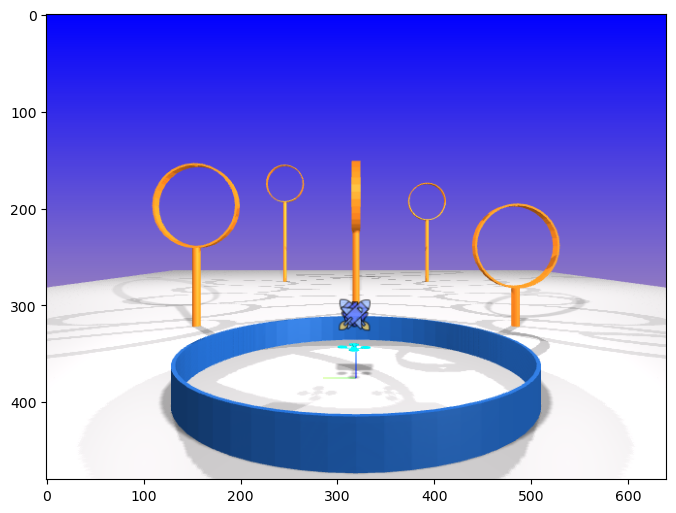

In [150]:
# Setting the width and height of the snapshot
simulator.set_snapshot_size(
    640, # <-- width
    480, # <-- height
)

# Getting snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot(
    'start_view',    # Name of view from which to take a snapshot
)

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

Saving the captured snapshot as a PNG image file named `snapshot.png`. Commented out for final submission.

In [151]:
# plt.imsave('snapshot.png', rgba)

We run the simulation until either the `max_time` is reached, all drones finish, or they are disqualified.

In [152]:
simulator.run(
    max_time=None,       # Run the simulation until all drones fail or finish
    print_debug=False,  # Print Nothing
)

We get result.

In [153]:
(
    did_it_fail,
    did_it_finish,
    what_time_did_it_finish,
) = simulator.get_result('template')

We show result.

In [154]:
if did_it_fail:
    print('The drone failed before finishing.')
elif did_it_finish:
    print(f'The drone finished at time {what_time_did_it_finish}')
else:
    print('The drone did not finish (yet).')

The drone finished at time 112.16


We get data.

In [155]:
data = simulator.get_data('template')

To evaluate the performance of the controller, the follwoing code runs the simulation multiple times with randomized seeds and logs key performance data. For each trial, the drone starts from a consistent initial state and attempts to complete the course using the same control strategy. Throughout the trials, the code records position errors between the actual and desired positions, observer estimation errors, the runtime of the controller at each timestep, and whether the drone successfully completes the course. After all trials are finished, the results are visualized using histograms and a live-updated success rate plot, providing insight into the controller's accuracy, stability, efficiency, and overall reliability.

argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=


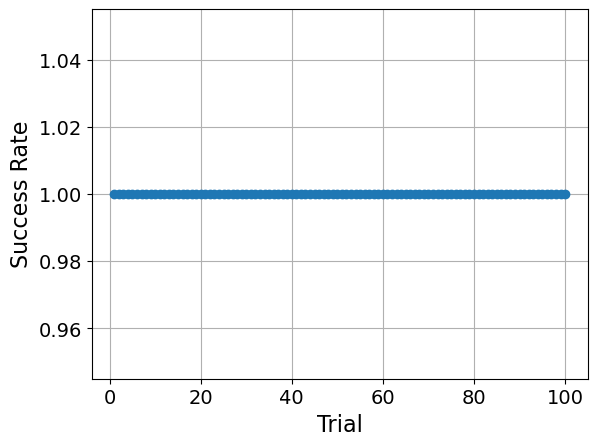


✅ Final Success Rate: 100.00%


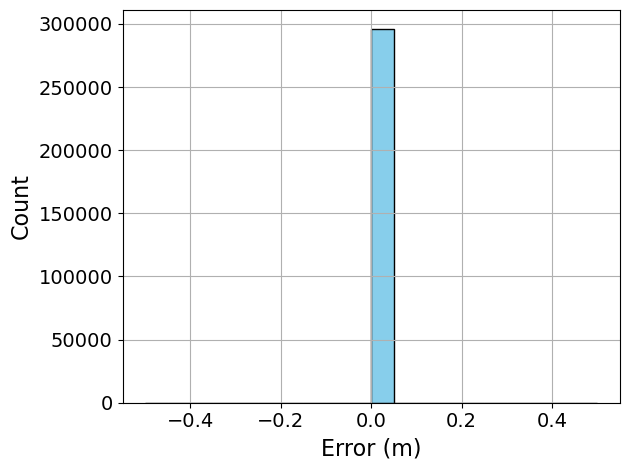

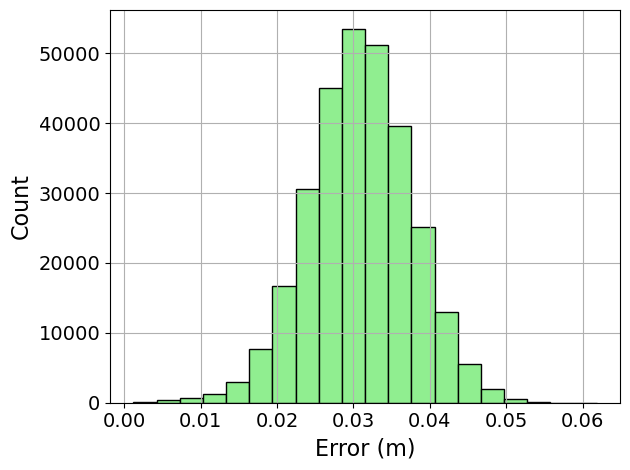

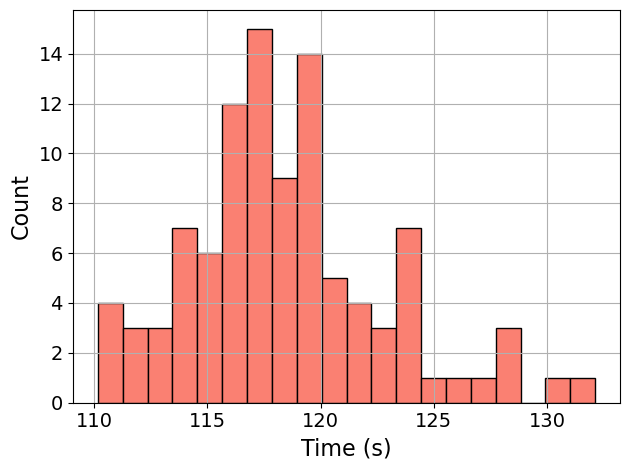

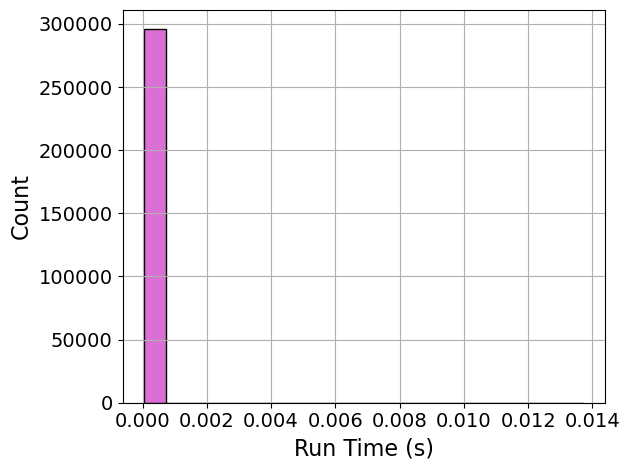


Out of 100 trials:
✅ Finished: 100
❌ Failed: 0
⏳ Timed out: 0


In [156]:
# Set number of trials to run and initialize storage for performance data
n_trials = 100
completion_times = []   # Time taken to complete the course (NaN if failed)
position_errors = []    # Position error between desired and actual position
observer_errors = []    # Estimation error between observer state and actual position
run_times = []          # Controller runtime per step
did_finish_list = []    # Whether each trial succeeded
did_fail_list = []      # Whether each trial failed
success_rate = []       # Cumulative success rate across trials
trial_numbers = []      # Trial index for plotting

# Loop over multiple trials to gather aggregate performance metrics
for trial in range(1, n_trials + 1):
    seed = np.random.randint(0, 2**32)  # Generate a random seed for reproducibility
    simulator = ae353_drone.Simulator(seed=seed)
    simulator.disable_views()  # Disable visualizations for faster simulation
    simulator.clear_drones()   # Ensure no drones from previous trials are present

    # Define a controller subclass that logs data during simulation
    class LoggingController(Controller):
        def __init__(self):
            super().__init__()
            self.pos_err_log = []  # Log of position errors
            self.obs_err_log = []  # Log of observer estimation errors
            self.run_times = []    # Log of execution time for each control step

        def run(self, pos_markers, pos_ring, dir_ring, is_last_ring, pos_others):
            start = time.perf_counter()  # Start timing the control step
            output = super().run(pos_markers, pos_ring, dir_ring, is_last_ring, pos_others)
            end = time.perf_counter()

            self.run_times.append(end - start)  # Log execution time

            pos_actual = (pos_markers[:3] + pos_markers[3:]) / 2  # Estimate actual position

            # If desired state is available, log position error
            if hasattr(self, 'x_des'):
                pos_des = self.x_des[:3]
                self.pos_err_log.append(np.linalg.norm(pos_actual - pos_des))
            else:
                self.pos_err_log.append(0.0)

            # Log observer estimation error
            self.obs_err_log.append(np.linalg.norm(self.xhat[:3] - pos_actual))

            return output

    # Create and add the logging controller to the simulator
    ctrl = LoggingController()
    simulator.add_drone(lambda: ctrl, 'template', 'New.png')

    # Reset the drone to a consistent starting state for fair evaluation
    simulator.reset(initial_conditions={
        'template': {
            'p_x': 0., 'p_y': 0., 'p_z': 0.5,
            'yaw': 0., 'pitch': 0., 'roll': 0.,
            'v_x': 0., 'v_y': 0., 'v_z': 0.,
            'w_x': 0., 'w_y': 0., 'w_z': 0.,
            'p_x_meas': 0., 'p_y_meas': 0., 'p_z_meas': 0.5,
            'yaw_meas': 0.
        }
    })

    # Run the simulation with no time limit or debug printing
    simulator.run(max_time=180, print_debug=False)

    # Get results from this trial: did the drone finish or fail?
    result = simulator.get_result('template')
    if result is not None:
        did_fail, did_finish, finish_time = result
    else:
        did_fail, did_finish, finish_time = True, False, np.nan

    # Record trial outcomes and performance data
    did_finish_list.append(did_finish)
    did_fail_list.append(did_fail)
    completion_times.append(finish_time if did_finish else np.nan)
    position_errors.extend(ctrl.pos_err_log)
    observer_errors.extend(ctrl.obs_err_log)
    run_times.extend(ctrl.run_times)

    trial_numbers.append(trial)
    successes_so_far = np.sum(did_finish_list)
    success_rate.append(successes_so_far / trial)

    # Live success rate plot update every 100 trials or on last trial
    if trial % 100 == 0 or trial == n_trials:
        plt.figure(1)
        plt.clf()
        plt.plot(trial_numbers, success_rate, marker='o', linestyle='-')
        plt.xlabel("Trial", fontsize=16)
        plt.ylabel("Success Rate", fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(True)
        plt.pause(0.1)

# Print final overall success rate
print(f"\n✅ Final Success Rate: {success_rate[-1] * 100:.2f}%")
plt.show()  # Make sure the final plot is displayed

# Plot histogram of position error across all trials
plt.figure()
plt.hist(position_errors, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Error (m)", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid(True)
plt.show()

# Plot histogram of observer (state estimate) error
plt.figure()
plt.hist(observer_errors, bins=20, color='lightgreen', edgecolor='black')
plt.xlabel("Error (m)", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid(True)
plt.show()

# Plot histogram of successful completion times (ignores NaNs)
plt.figure()
plt.hist([t for t in completion_times if not np.isnan(t)], bins=20, color='salmon', edgecolor='black')
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid(True)
plt.show()

# Plot histogram of runtime per control step
plt.figure()
plt.hist(run_times, bins=20, color='orchid', edgecolor='black')
plt.xlabel("Run Time (s)", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid(True)
plt.show()

# Print a final summary of outcomes
print(f"\nOut of {n_trials} trials:")
print(f"✅ Finished: {sum(did_finish_list)}")
print(f"❌ Failed: {sum(did_fail_list)}")
print(f"⏳ Timed out: {n_trials - sum(did_finish_list) - sum(did_fail_list)}")



This section evaluates the controller's performance in a multi-drone setting by simulating 10 drones running in parallel across multiple trials. In each trial, 10 drones are initialized with random seeds and placed into the simulator. After running the simulation, the number of drones that successfully finish the course is recorded. The success percentage for each trial is plotted live to visualize consistency and scalability of the controller across multiple agents. At the end, the average success rate is printed.

argv[0]=
Trial 1: ✅ 9/10 drones finished


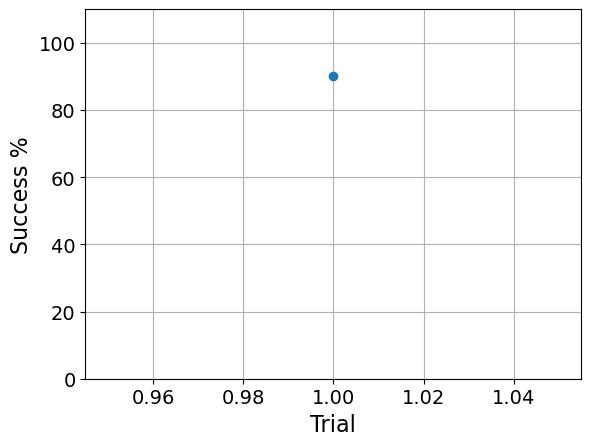

argv[0]=
Trial 2: ✅ 9/10 drones finished


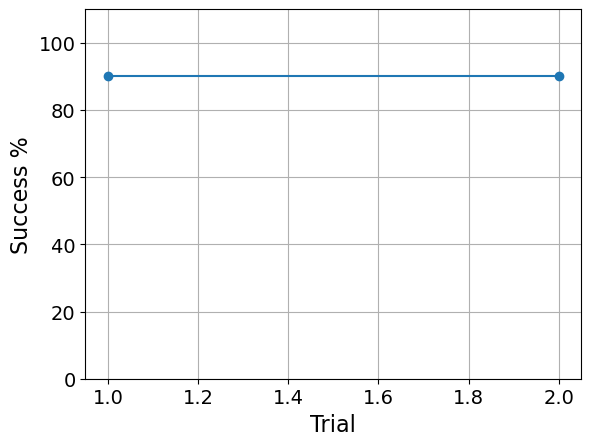

argv[0]=
Trial 3: ✅ 7/10 drones finished


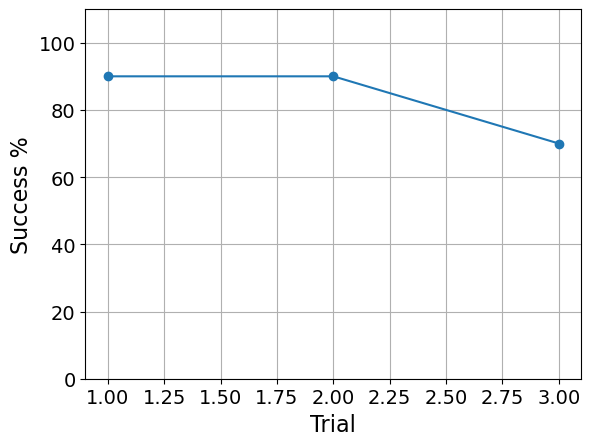

argv[0]=
Trial 4: ✅ 10/10 drones finished


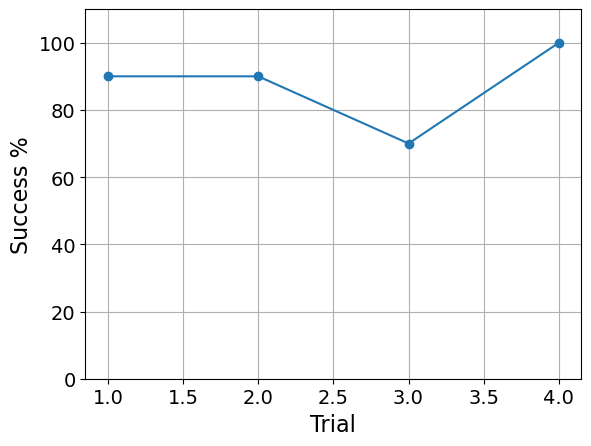

argv[0]=
Trial 5: ✅ 10/10 drones finished


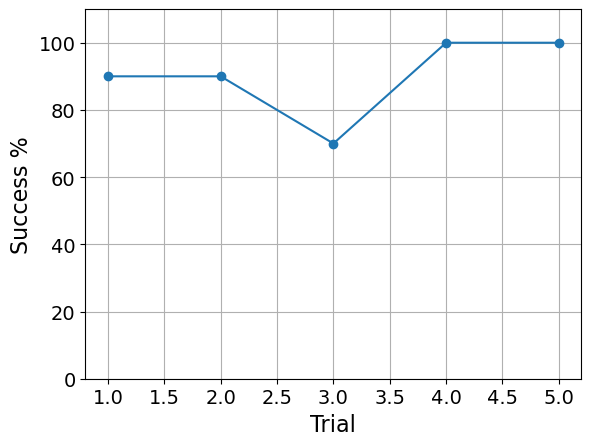

argv[0]=
Trial 6: ✅ 10/10 drones finished


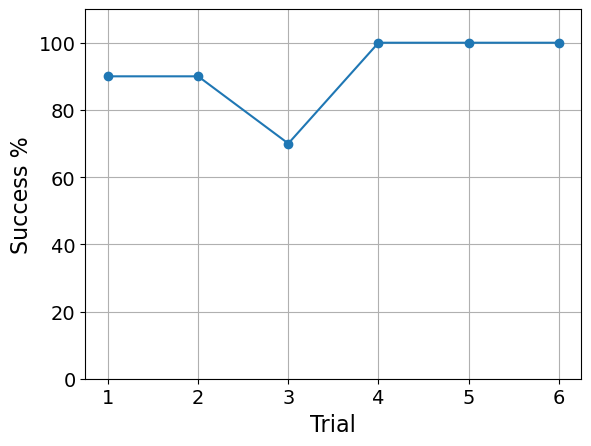

argv[0]=
Trial 7: ✅ 8/10 drones finished


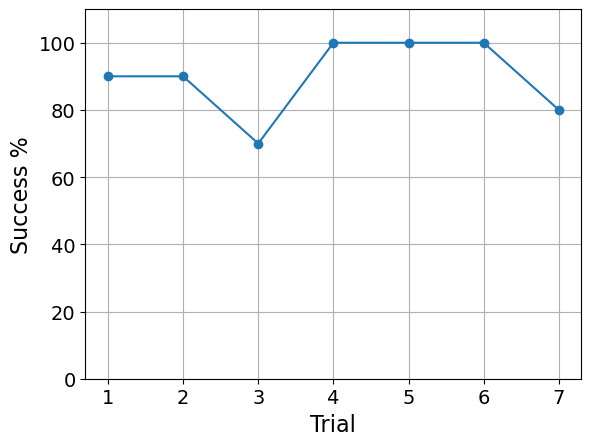

argv[0]=
Trial 8: ✅ 8/10 drones finished


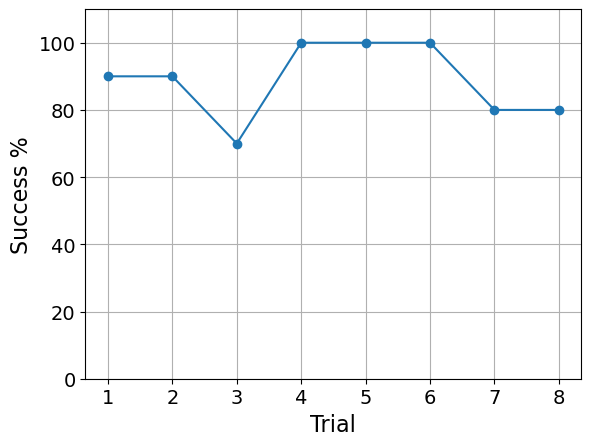

argv[0]=
Trial 9: ✅ 10/10 drones finished


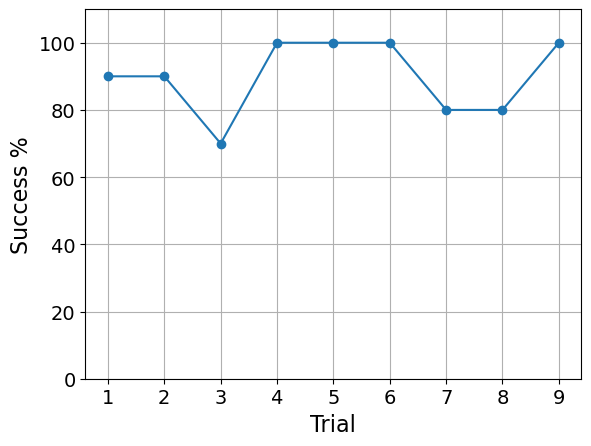

argv[0]=
Trial 10: ✅ 10/10 drones finished


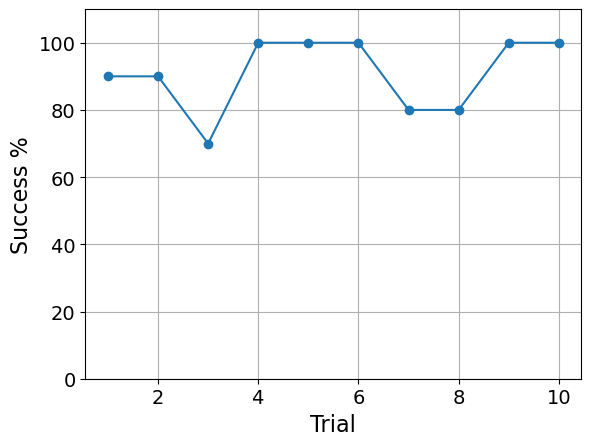


✅ Average success rate: 91.00%


In [157]:
# Set number of trials to run
n_trials = 10

# Lists to track success percentage and trial numbers
trial_success_percentages = []
trial_numbers = []

# Loop over multiple trials
for trial in range(1, n_trials + 1):
    # Generate a random seed for reproducibility
    seed = np.random.randint(0, 2**32)

    # Initialize simulator with random seed and no views
    simulator = ae353_drone.Simulator(seed=seed)
    simulator.disable_views()
    simulator.clear_drones()

    # Add 10 drones with unique names (t, t2, ..., t10)
    drone_names = [f't{i}' if i > 1 else 't' for i in range(1, 11)]
    for name in drone_names:
        simulator.add_drone(lambda: Controller(), name, 'New.png')

    # Reset the simulator with default initial positions
    simulator.reset()

    # Run the simulation without a time limit or debug output
    simulator.run(max_time=180, print_debug=False)

    # Count how many drones successfully finished
    num_finished = 0
    for name in drone_names:
        try:
            result = simulator.get_result(name)
            if result is not None:
                _, did_finish, _ = result
                if did_finish:
                    num_finished += 1
        except KeyError:
            # Handle case where the result is missing
            pass

    # Record trial results
    trial_success_percentages.append((num_finished / 10) * 100)
    trial_numbers.append(trial)

    # Print summary for the current trial
    print(f"Trial {trial}: ✅ {num_finished}/10 drones finished")

    # Update live success plot
    if trial % 1 == 0 or trial == n_trials:
        plt.figure(1)
        plt.clf()
        plt.plot(trial_numbers, trial_success_percentages, marker='o')
        plt.xlabel("Trial", fontsize=16)
        plt.ylabel("Success %", fontsize=16)
        plt.ylim(0, 110)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(True)
        plt.pause(0.1)

# Show final plot
plt.show()

# Print average success rate across all trials
print(f"\n✅ Average success rate: {np.mean(trial_success_percentages):.2f}%")
